# Business Understanding

Apart documentje

# Data Understanding

De images inladen met de steering waarde als label. De steering value staat in de filename van elke image.

In [4]:
#imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, losses, Model
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os, os.path

path = "data"
imgs = []
labels = []
res_x = 224
res_y = 224
# put image in a list
for f in os.listdir(path):
    # To only get images that have -1 (left), -0.00392 (straight) and 1 (right)
    if f.split('_')[0] == '-1.0' or f.split('_')[0] == '1.0' or f.split('_')[0] == '-0.00392':
        labels.append(f.split('_')[0])
        image = tf.keras.preprocessing.image.load_img(os.path.join(path, f), grayscale=False, color_mode="rgb", target_size=(res_x, res_y)) # 224x224 resolutie gekozen, bij moeilijkheden terugschroeven naar bijv 64x64
        imgs.append(np.asarray(image))
    
imgs = np.array(imgs) 
labels = np.array(labels)

In [5]:
print(imgs)

[[[[ 97  62  66]
   [ 95  60  64]
   [ 96  61  67]
   ...
   [ 98  56  66]
   [105  62  72]
   [106  63  73]]

  [[108  73  77]
   [103  68  72]
   [ 99  64  70]
   ...
   [ 94  54  63]
   [ 92  52  61]
   [ 93  53  62]]

  [[113  78  82]
   [107  72  76]
   [102  67  73]
   ...
   [ 99  64  71]
   [ 95  59  69]
   [ 94  58  68]]

  ...

  [[182 103 109]
   [178  98 107]
   [177 100 108]
   ...
   [178 128 163]
   [175 125 160]
   [174 124 159]]

  [[181 102 108]
   [179 100 106]
   [179 102 110]
   ...
   [178 128 163]
   [177 127 162]
   [176 126 161]]

  [[178  99 105]
   [182 103 109]
   [180 103 111]
   ...
   [178 126 162]
   [179 129 164]
   [176 126 161]]]


 [[[120  73  79]
   [118  71  77]
   [125  80  85]
   ...
   [ 65  33  48]
   [120  74  87]
   [165 109 122]]

  [[122  75  81]
   [119  72  78]
   [127  82  87]
   ...
   [ 67  35  50]
   [121  77  90]
   [158 102 115]]

  [[125  78  84]
   [116  71  76]
   [128  83  88]
   ...
   [ 64  33  48]
   [119  75  88]
   [157 101

In [6]:
print(len(imgs))
print(imgs.shape)

1087
(1087, 224, 224, 3)


In [7]:
labels = np.asarray(labels).astype(np.float32)
labels = labels.reshape(len(labels), 1)
print(labels)

[[-0.00392]
 [-0.00392]
 [-0.00392]
 ...
 [ 1.     ]
 [ 1.     ]
 [ 1.     ]]


De steering waarde zit tussen de 1 en -1. Dit is ook vaak -0.00392, maar dit komt door een kleine stickdrift. Bij deze waarde gaat de auto rechtdoor. 

In [8]:
print(len(labels))
print(labels.shape)

1087
(1087, 1)


In [9]:
print(np.unique(labels))
print(len(np.unique(labels)))
(unique, counts) = np.unique(labels, return_counts=True)
print(unique, counts)

[-1.      -0.00392  1.     ]
3
[-1.      -0.00392  1.     ] [262 488 337]


In [10]:
#normaliseer de data om de negatieve waardes eruit te halen
norm_labels = (labels-min(labels))/(max(labels)-min(labels))

In [11]:
rev_labels = (norm_labels * 2) - 1
rev_labels = np.round(rev_labels, 5)
rev_labels

array([[-0.00392],
       [-0.00392],
       [-0.00392],
       ...,
       [ 1.     ],
       [ 1.     ],
       [ 1.     ]], dtype=float32)

<AxesSubplot:ylabel='Count'>

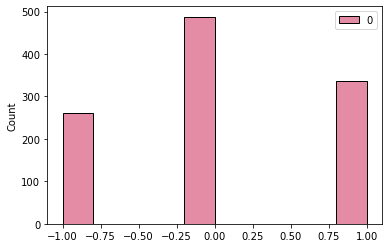

In [12]:
#check mbv histogrammen of de data hetzelfde eruitziet, maar de as is veranderd
sns.histplot(labels, bins=10, palette='rocket')


<AxesSubplot:ylabel='Count'>

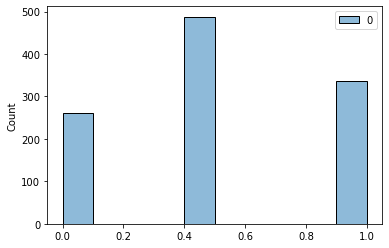

In [13]:
sns.histplot(norm_labels, bins=10)

<AxesSubplot:ylabel='Count'>

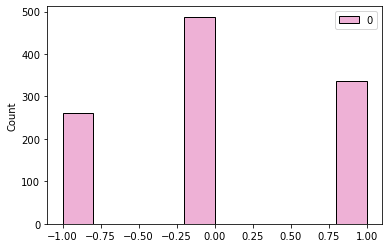

In [14]:
sns.histplot(rev_labels, bins=10, palette='PuRd') 

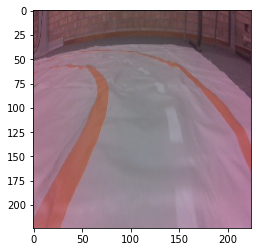

In [15]:


plt.imshow(imgs[0])   

# Data Preparation

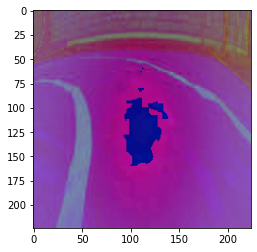

In [16]:
# Masks 
# hsv in plaats van rgb maakt het makkelijker om lichtinvloeden weg te halen bij de volgende stappen van de masks
import cv2
hsv_img = []
for x in imgs:
    # cv2 is raar en gebruikt bgr in plaats van rgb
    hsv_img.append(cv2.cvtColor(x, cv2.COLOR_BGR2HSV))
plt.imshow(hsv_img[1])
hsv_img = np.array(hsv_img)

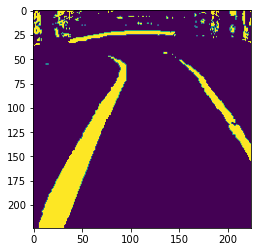

In [17]:
# test om mask te maken voor de lijn
#
# eerst met sv values van 10 geprobeerd maar hogere waardes halen meer van de noise in de achtergrond weg.
# wel oppassen dat de lijn niet stukjes gaat missen.
# 90 lijkt ok maar kan nog meer getest worden
lower_yellow = np.array([10, 90, 90])
# verschillende waardes geprobeerd, 120 haalt het linkerdeel van de lijn weg en 130 neemt te veel achtergrond mee.
# 125 it is.
upper_yellow = np.array([125, 255, 255]) 
test = cv2.inRange(hsv_img[60], lower_yellow, upper_yellow)
plt.imshow(test)

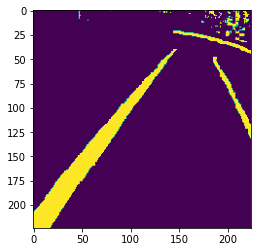

In [18]:
# mask alle images met bovengestelde bounds
masked_img = []
for hsv in hsv_img:
    masked_img.append(cv2.inRange(hsv, lower_yellow, upper_yellow))
plt.imshow(masked_img[5])
masked_img = np.array(masked_img)

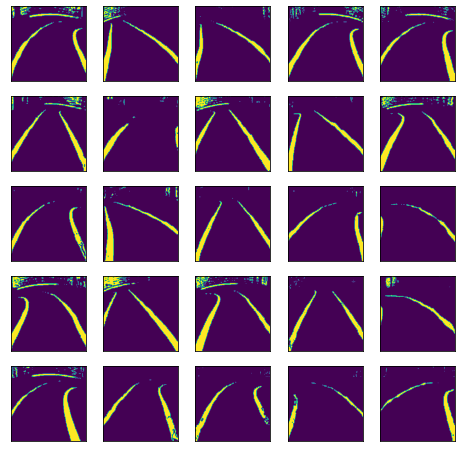

In [19]:
# laat een paar random masks zien om kwaliteit te checken
import random
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(masked_img[random.randint(0,300)]) 
plt.show()

In [20]:
# laat canny de randen van de lijn herkennen
edged_img = []
for mask in masked_img:
    edged_img.append(cv2.Canny(mask, 200, 400)) #online werd geschreven dat 200 400 over het algemeen de beste waarden zijn en het resultaat ziet er goed uit. zie voor bron https://towardsdatascience.com/deeppicar-part-4-lane-following-via-opencv-737dd9e47c96
edged_img = np.array(edged_img)

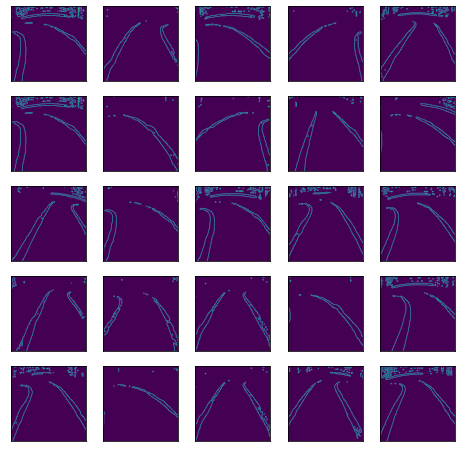

In [21]:
# laat een paar random randen zien om kwaliteit te checken
import random
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(edged_img[random.randint(0,300)]) 
plt.show()

In [22]:
def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # haal bovenste deel met clutter weg. orgineel haalde 50% weg, ik denk dat 20% weghalen meer bruikbare data oplevert
    polygon = np.array([[
        (0, height * 2 / 10),
        (width, height * 2 / 10),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

In [23]:

decluttered_edged_img = []
# haal het bovenste deel van de foto weg om clutter tegen te gaan
for img in edged_img:
    decluttered_edged_img.append(region_of_interest(img))
decluttered_img = np.array(decluttered_edged_img)

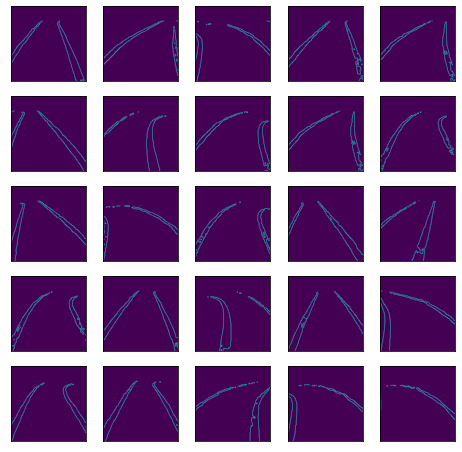

In [24]:
# laat een paar random randen zien om kwaliteit te checken
import random
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(decluttered_edged_img[random.randint(0,300)]) 
plt.show()

In [ ]:
from sklearn import preprocessing

# Transforms it into 0, 1, 2
le = preprocessing.LabelEncoder()
labels = norm_labels.ravel()
le.fit(np.unique(labels))
labels_transform = le.transform(labels)

In [ ]:
print(labels_transform)

[1 1 1 ... 2 2 2]


In [ ]:
labels_transform = labels_transform.reshape(len(labels_transform), 1)
print(labels_transform.shape)

(1087, 1)


In [ ]:
from sklearn.model_selection import train_test_split

#maak een train test split met een test size van 30%
train_images, test_images, train_labels, test_labels = train_test_split(edged_img, labels_transform, test_size=0.3)

In [ ]:
#print de shapes om te kijken of er evenveel images als labels zijn
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_labels)

(760, 224, 224)
(327, 224, 224)
(760, 1)
(327, 1)
[[2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [0]
 [2]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [2]
 [1]
 [2]
 [2]
 [2]
 [0]
 [2]
 [2]
 [1]
 [2]
 [0]
 [0]
 [1]
 [2]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [2]
 [2]
 [1]
 [2]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [0]
 [1]
 [2]
 [1]
 [0]
 [2]
 [1]
 [1]
 [0]
 [2]
 [1]
 [2]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [0]
 [1]
 [2]
 [0]
 [1]
 [0]
 [1]
 [0]
 [2]
 [2]
 [0]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [0]
 [2]
 [2]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [2]
 [0]
 [2]
 [1]
 [0]
 [1]
 [0]
 [1]


# Modeling

In [ ]:
#nvidia model uit bovengenoemde bron, na deze te hebben getest concludeer ik dat de extreem lange traintijd geen significant verschil in performance geeft
# model = models.Sequential([
#     layers.Conv2D(24, (5,5) , activation="elu", input_shape=(res_x,res_y,1),),
#     layers.Conv2D(36, (5,5) , activation="elu"),
#     layers.Conv2D(48, (5,5) , activation="elu"),
#     layers.Conv2D(64, (3,3) , activation="elu"),
#     layers.Dropout(0.2),
#     layers.Conv2D(64, (3,3) , activation="elu"),
#     layers.Flatten(),
#     layers.Dropout(0.2),
#     layers.Dense(100, activation="elu"),
#     layers.Dense(50, activation="elu"),
#     layers.Dense(10, activation="elu"),

#     #layers.Dense(1, activation="elu"),
    
# ])
# model.summary()
# model.compile(optimizer="ADAM",
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])

In [ ]:
# standaard image classificatiemodel
model = models.Sequential([
    layers.Conv2D(32, (3,3) , activation="relu", input_shape=(res_x,res_y,1),), # als de masks gebruikt worden moet na de edge stap 1 ipv 3 kleurkanalen gebruikt worden (dus een shape van res_x,res_y,1)
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(32, (3,3) , activation="relu"),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(100, activation="sigmoid")
    
])
model.summary()
model.compile(optimizer="ADAM",
              loss="sparse_categorical_crossentropy", 
              # we hebben ook getest met mse om de exacte stuuruitslag te voorspellen maar dit levert een accuracy van 20% op die behaald wordt door puur rechtdoor te gokken.
              # Als hij minder accuraat zou hoeven te voorspellen zou het model best kunnen werken alleen zijn wij er niet achtergekomen hoe dit moet.
              metrics=["accuracy"])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 96800)             0         
                                                                 
 dropout_7 (Dropout)         (None, 96800)            

In [ ]:
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

Epoch 1/5
24/24 [==============================] - 27s 1s/step - loss: 10.3295 - accuracy: 0.6882 - val_loss: 1.0269 - val_accuracy: 0.7034
Epoch 2/5
24/24 [==============================] - 30s 1s/step - loss: 0.2846 - accuracy: 0.8934 - val_loss: 0.7456 - val_accuracy: 0.7339
Epoch 3/5
24/24 [==============================] - 30s 1s/step - loss: 0.1131 - accuracy: 0.9592 - val_loss: 0.8868 - val_accuracy: 0.7370
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.0362 - accuracy: 0.9961 - val_loss: 1.0348 - val_accuracy: 0.7370
Epoch 5/5
24/24 [==============================] - 31s 1s/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 1.1308 - val_accuracy: 0.7339


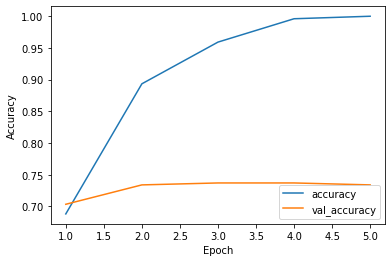

In [ ]:
# plot om acc en val_acc mooi te laten zien
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
model.save("model_no_masks")

INFO:tensorflow:Assets written to: model_no_masks\assets


INFO:tensorflow:Assets written to: model_no_masks\assets


In [ ]:
class_names = np.unique(labels)
class_names = np.asarray(class_names).astype(np.str0)
class_names[0] = 0
class_names[1] = 1
class_names[2] = 2
print(class_names)

['0' '1' '2']


In [ ]:
len(test_images)

327

In [ ]:
r = []
for i in range(25):
    r.append(random.randint(1,50))

1/1 [==============================] - 0s 390ms/step


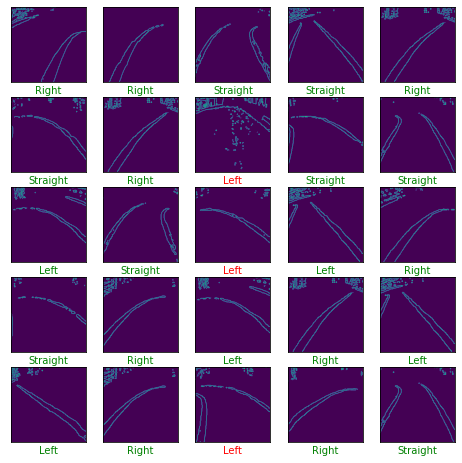

In [ ]:
predict = model.predict(test_images[r])
x = 0
# predict 25 random images en laat ze zien. het label is wat de auto voorspelt en de kleur geeft aan of de voorspelling goed was

plt.figure(figsize=(8,8))
for i in r:
    plt.subplot(5,5,x+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i])
    if class_names[predict[x].argmax()].astype(int) == test_labels[i]:
        if test_labels[i] == 0:
            plt.xlabel('Left').set_color('green')
        if test_labels[i] == 1:
            plt.xlabel('Straight').set_color('green')
        if test_labels[i] == 2:
            plt.xlabel('Right').set_color('green')
    elif class_names[predict[x].argmax()].astype(int) != test_labels[i]:
        if test_labels[i] == 0:
            plt.xlabel('Left').set_color('red')
        if test_labels[i] == 1:
            plt.xlabel('Straight').set_color('red')
        if test_labels[i] == 2:
            plt.xlabel('Right').set_color('red')
    x+=1
plt.show()

# Evaluation



normale img geeft score van 78%
hsv geeft score van 70%
masked geeft score van 77%
edged geeft score van 80%
decluttered geeft score van 75%

De verschillende stappen van de masks maken dus niet zoveel verschil maar wat ik wel merkte is dat de accuracy bij de latere masks veel sneller omhoog liep als bij de normale images. Het model overfit dus sneller met de masks. Ik verwacht dat dit komt omdat de masks de afbeeldingen minder gecompliceerd maken en daardoor zijn er minder features waar het model iets aan kan tweaken en dus vindt hij heel snel het optimum.

in de conv2d layers de neurons verhogen zorgt dat hij sneller op de max val_acc zit, zelfde effect als hierboven

# Deployment